In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("/content/drive/MyDrive/S-prediction/2022_BAU_10AEZ_Nutrients_sortedForSensitivityTest - Sheet1.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/S-prediction/2022_BAU_10AEZ_Nutrients_sortedForSensitivityTest - Sheet1.csv'

In [1082]:
df.head()

,S/N,AEZ,N (%),P (mg/kg),K (meq/100 g soil),S (mg/kg),pH
0,1,1,0.10,12.96,0.14,16.71,5.14
1,2,1,0.07,25.10,0.13,15.39,5.09
2,3,1,0.11,8.91,0.15,17.37,4.95
3,4,1,0.12,21.05,0.15,19.34,4.57
4,5,1,0.10,12.96,0.12,18.03,4.38


In [1083]:
df.duplicated().sum()

np.int64(0)

In [1084]:
df.isna().sum()

,0
S/N,0
AEZ,0
N (%),0
P (mg/kg),0
K (meq/100 g soil),0
S (mg/kg),10
pH,0


In [1085]:
df.dropna(axis=0, inplace=True)
df.isna().sum()

,0
S/N,0
AEZ,0
N (%),0
P (mg/kg),0
K (meq/100 g soil),0
S (mg/kg),0
pH,0


In [1086]:
df = df.rename(columns={
    "S/N": "sn",
    "AEZ": "aez",
    "N (%)": "n",
    "P (mg/kg)": "p",
    "K (meq/100 g soil)": "k",
    "S (mg/kg)": "s",
    "pH": "ph"
})


In [1087]:
df.drop(columns="sn", inplace=True)

In [1088]:
df.describe()

,aez,n,p,k,s,ph
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,15.400000,0.104333,14.277267,0.146267,32.375700,6.174267
std,9.918059,0.038991,8.500542,0.092783,51.200491,1.157405
min,1.000000,0.030000,0.820000,0.030000,0.560000,4.220000
25%,9.000000,0.070000,8.000000,0.080000,10.750000,5.200000
50%,12.000000,0.100000,12.000000,0.120000,16.655000,5.815000
75%,26.000000,0.120000,18.285000,0.170000,24.425000,7.102500
max,29.000000,0.240000,45.760000,0.500000,249.000000,8.860000


In [1089]:
df.shape

(300, 6)

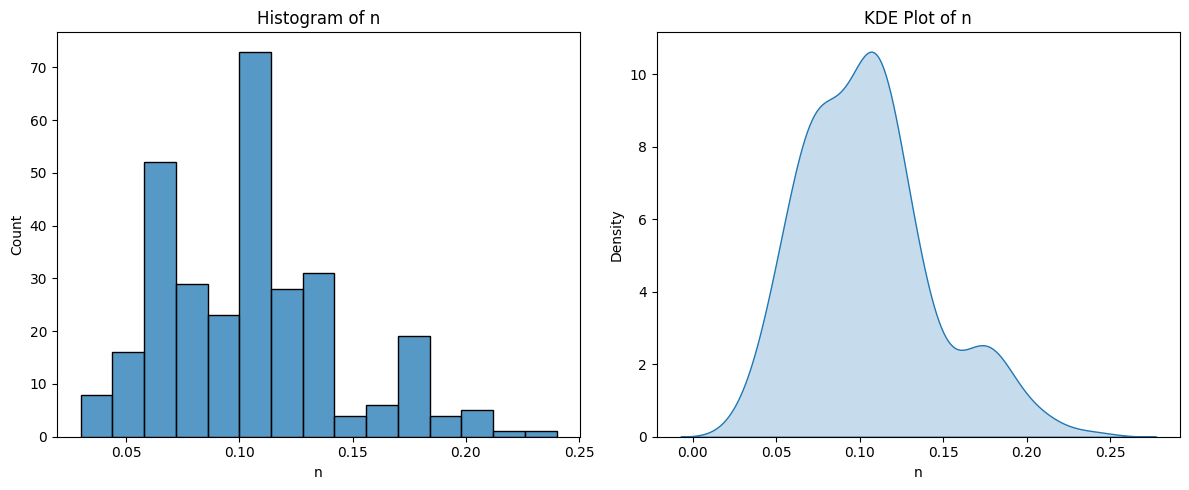

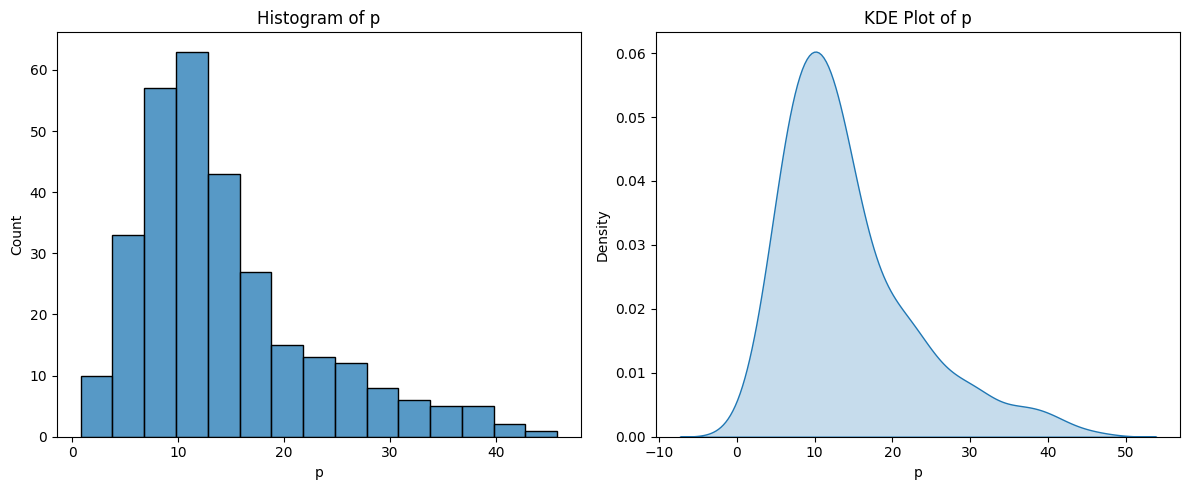

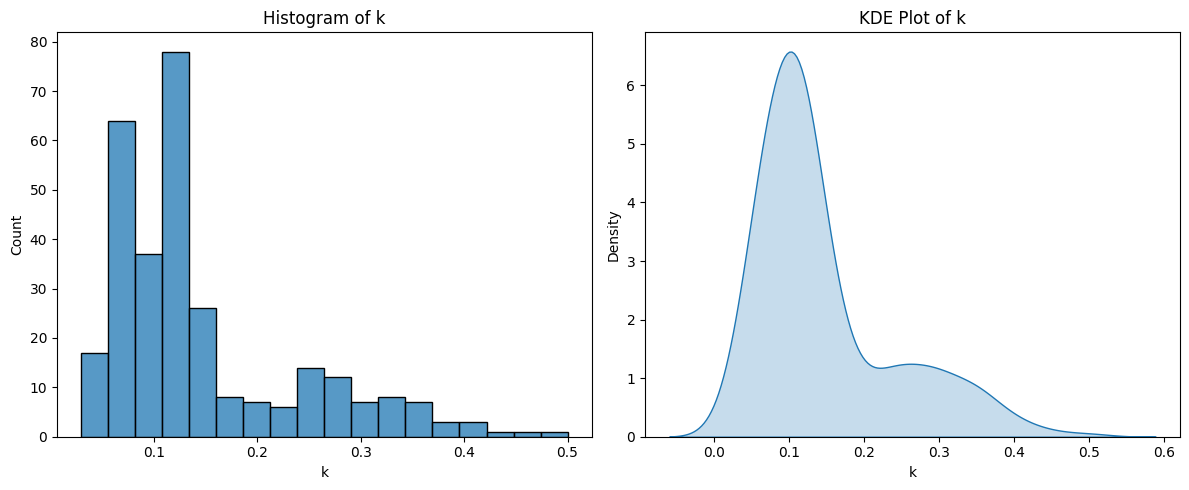

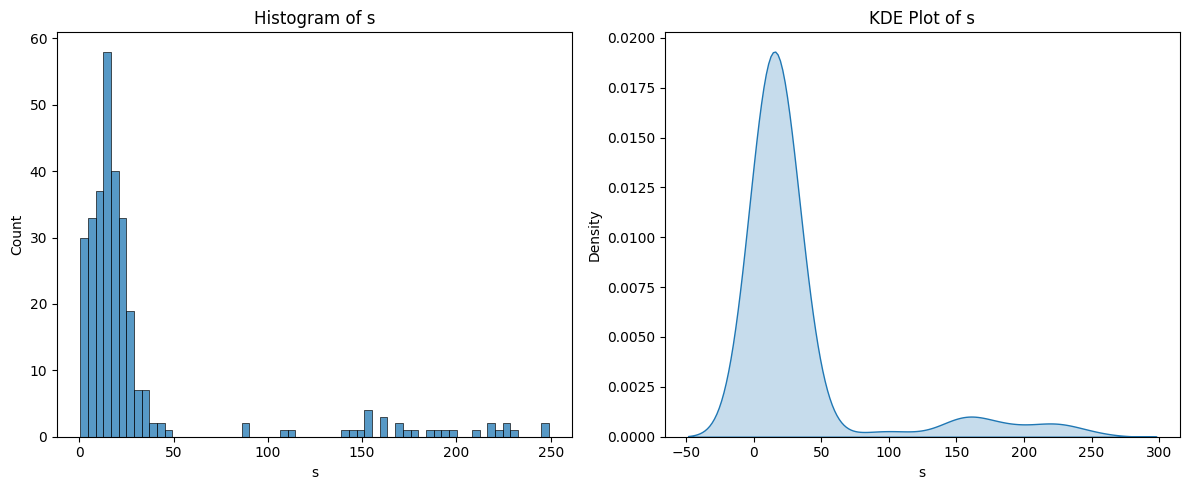

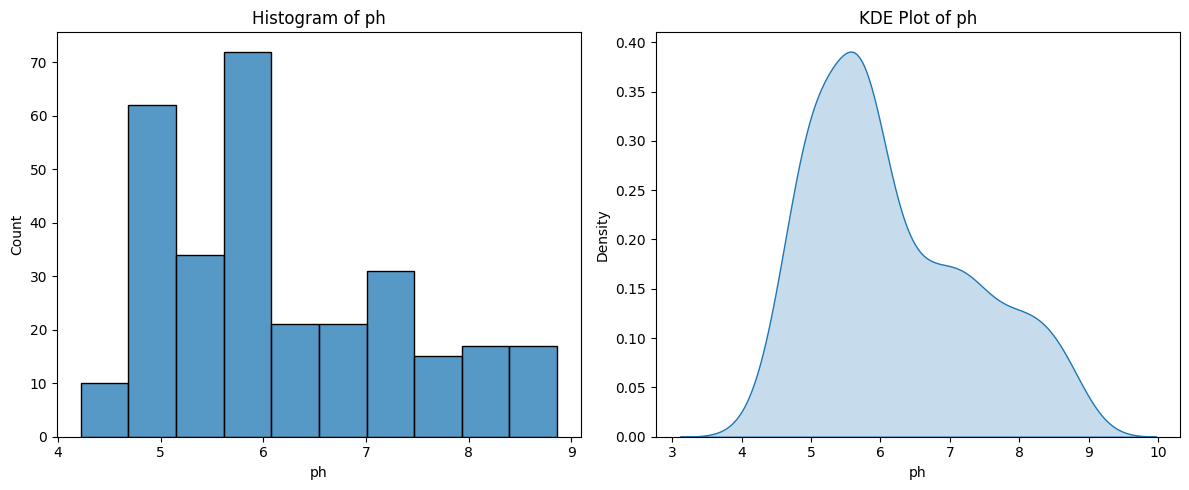

In [1090]:
cols = [c for c in df.columns if c != "aez"]


for c in cols:
  fig, axes = plt.subplots(1,2,figsize=(12,5))

  sns.histplot(df[c], ax=axes[0])
  axes[0].set_title(f"Histogram of {c}")
  axes[0].set_xlabel(c)

  sns.kdeplot(df[c], fill=True, ax=axes[1])
  axes[1].set_title(f"KDE Plot of {c}")
  axes[1].set_xlabel(c)

  plt.tight_layout()
  plt.show()

<Axes: xlabel='aez'>

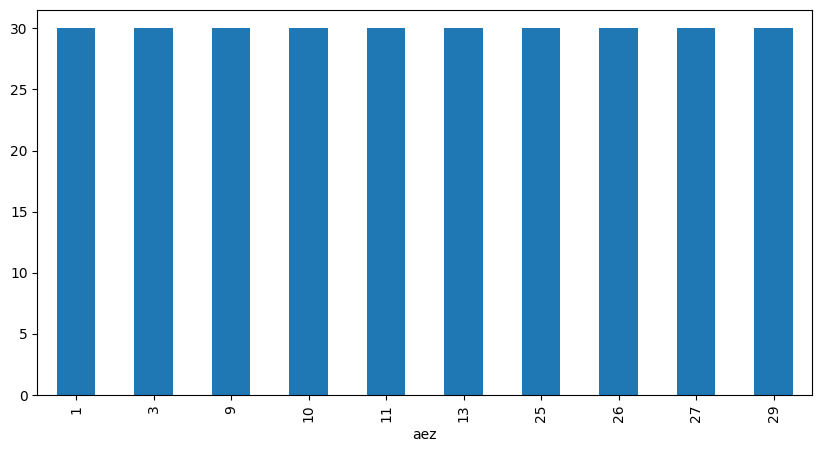

In [1091]:
df["aez"].value_counts().sort_index().plot(kind="bar", figsize=(10,5))

In [1092]:
df = df[df["aez"] != 13]

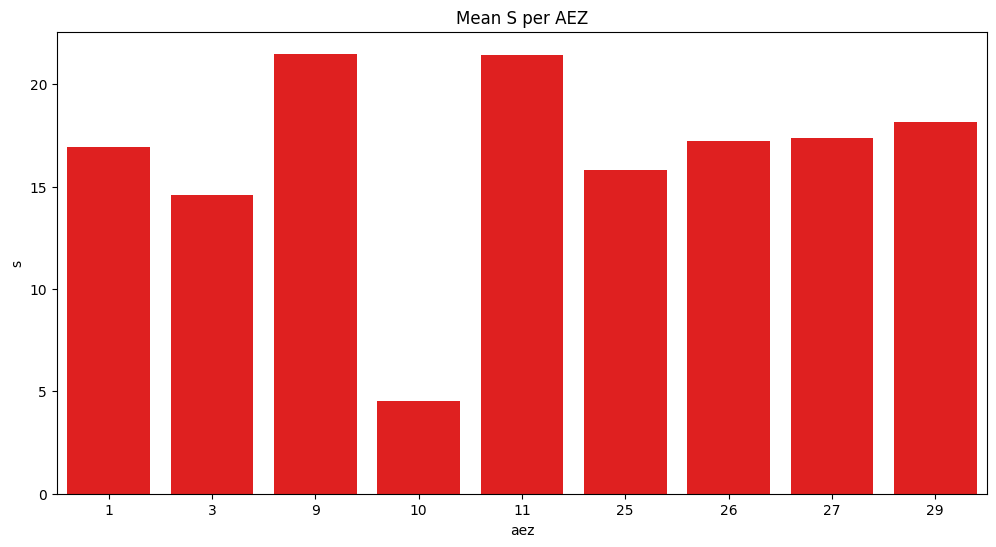

In [1093]:
means = df.groupby("aez")["s"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=means, x="aez", y="s", color="red")

plt.title("Mean S per AEZ")
plt.xlabel("aez")
plt.ylabel("s")
plt.show()

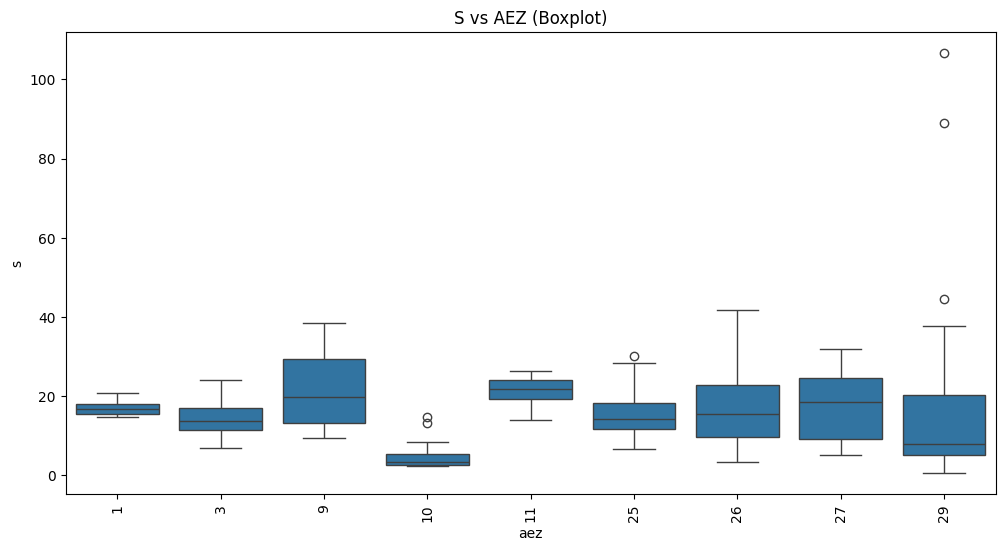

In [1094]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="aez", y="s")
plt.xticks(rotation=90)
plt.title("S vs AEZ (Boxplot)")
plt.show()


In [1095]:
def remove_outliers(df):
    df_clean = []
    for aez in df["aez"].unique():
        part = df[df["aez"] == aez]
        Q1 = part["s"].quantile(0.25)
        Q3 = part["s"].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean.append(part[(part["s"] >= lower) & (part["s"] <= upper)])
    return pd.concat(df_clean)

df = remove_outliers(df)

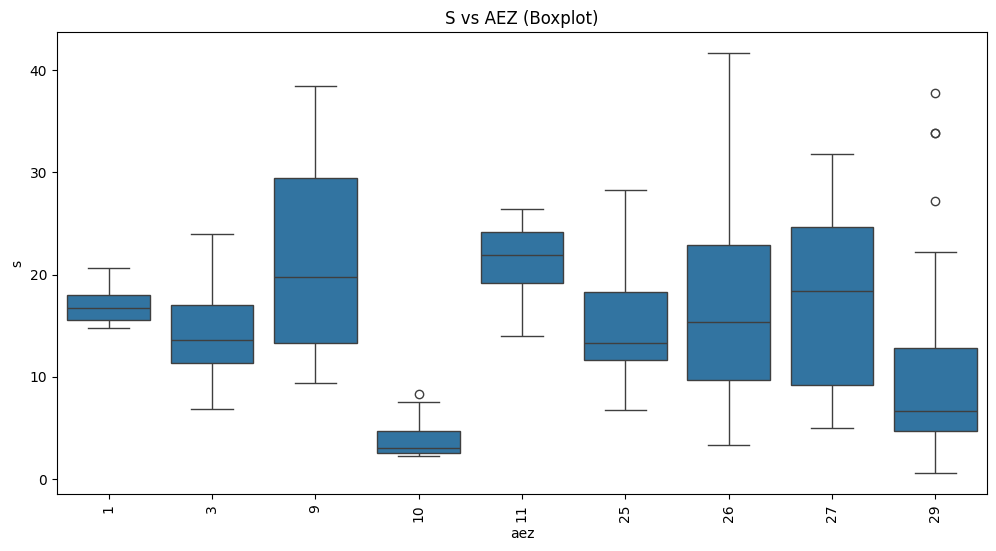

In [1096]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="aez", y="s")
plt.xticks(rotation=90)
plt.title("S vs AEZ (Boxplot)")
plt.show()

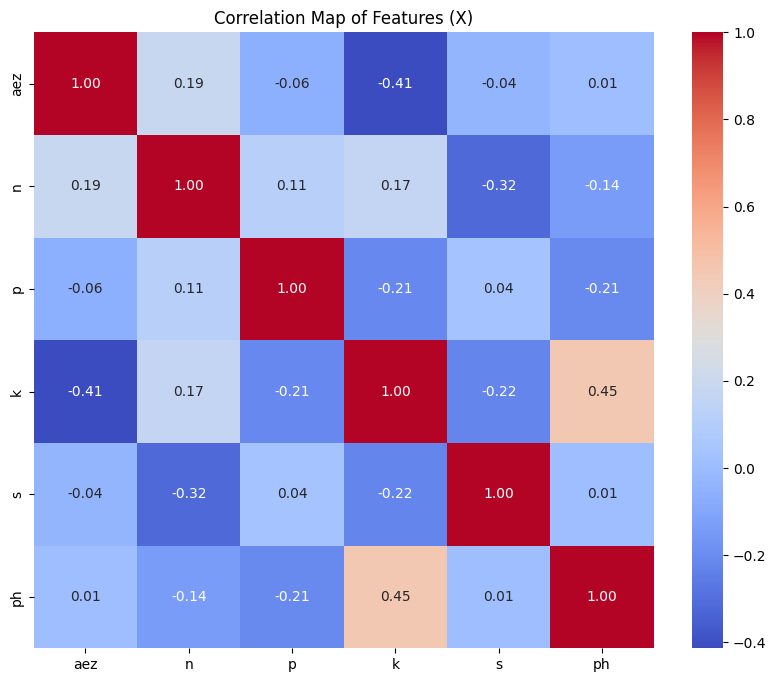

In [1097]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Map of Features (X)")
plt.show()

In [1098]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(df[["aez"]], df["s"])
print("Mutual information between aez and s:", mi[0])

Mutual information between aez and s: 0.5061028380056998


In [1099]:
df.dtypes

,0
aez,int64
n,float64
p,float64
k,float64
s,float64
ph,float64


In [1100]:
X = df.drop(columns="s")
y = df["s"]
print(X.shape, y.shape)

(264, 5) (264,)


In [1101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [1102]:
numeric_features = [c for c in X_train.columns if c != "aez"]
categorical_features = ["aez"]

In [1103]:
X_train[categorical_features].apply(lambda s: s.unique())

,aez
0,11
1,25
2,10
3,27
4,1
5,26
6,3
7,9
8,29


In [1104]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler_X = StandardScaler()
X_train_num = scaler_X.fit_transform(X_train[numeric_features])
X_test_num = scaler_X.transform(X_test[numeric_features])

encoder_X = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_cat = encoder_X.fit_transform(X_train[categorical_features])
X_test_cat  = encoder_X.transform(X_test[categorical_features])

X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed  = np.hstack([X_test_num, X_test_cat])

scaler_y = StandardScaler()
#y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))

In [1105]:
print(X_train_processed.shape)
print(y_train_scaled.shape)

(237, 13)
(237, 1)


In [1106]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])


In [1107]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

In [1108]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

In [1109]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_processed, y_train,
    validation_split=0.3,
    epochs=800,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 326.7495 - mae: 16.0302 - val_loss: 293.2346 - val_mae: 14.5918
Epoch 2/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 308.2882 - mae: 15.7575 - val_loss: 275.8856 - val_mae: 13.9829
Epoch 3/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 265.7802 - mae: 14.1276 - val_loss: 257.3304 - val_mae: 13.3061
Epoch 4/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 269.2827 - mae: 14.2980 - val_loss: 234.2774 - val_mae: 12.4303
Epoch 5/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 236.0095 - mae: 12.8716 - val_loss: 208.1872 - val_mae: 11.4324
Epoch 6/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 209.6186 - mae: 12.3099 - val_loss: 178.5299 - val_mae: 10.3581
Epoch 7/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 175.6224 - mae: 10.7952 - val_loss: 148.2361 - val_mae: 9.3603
Epoch 8/800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 121.3070 - mae: 8.8831 - val_loss: 119.5746 - val_mae: 8.4880
Epoch 9/800
21/21

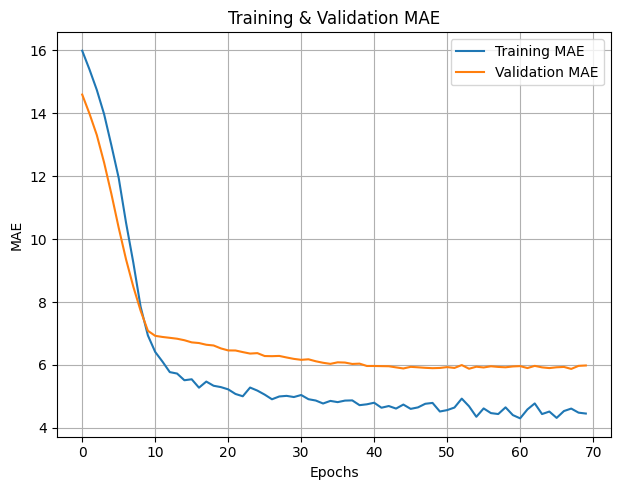

In [1110]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history

# --- Plot LOSS ---
plt.figure(figsize=(12,5))


# --- Plot MAE ---
plt.subplot(1,2,2)
plt.plot(history_dict["mae"], label="Training MAE")
plt.plot(history_dict["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training & Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [1111]:
y_pred = model.predict(X_test_processed).flatten()
#y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [1112]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

y_test shape: (27,)
y_pred shape: (27,)


In [1113]:
from sklearn.metrics import mean_squared_error, r2_score

mae = np.mean(np.abs(y_test - y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 4.3364272820508045
RMSE: 5.225069530187921
R²: 0.45104236869824166


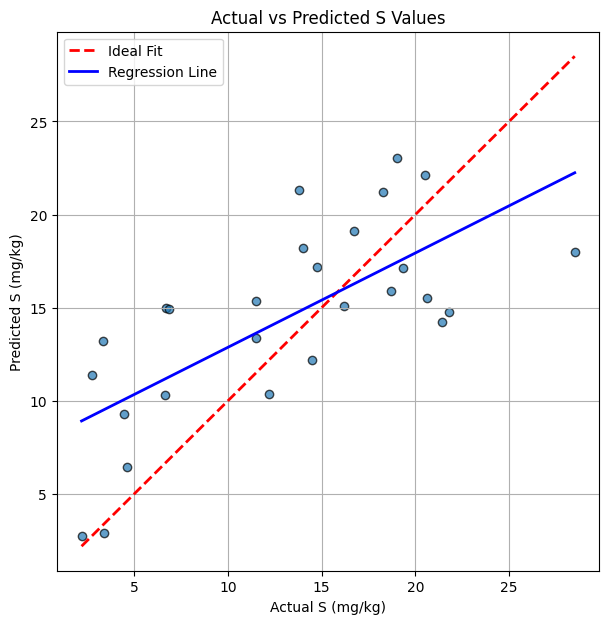

In [1114]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Flatten test values
y_test_flat = np.array(y_test).flatten()
y_pred_flat = np.array(y_pred).flatten()

plt.figure(figsize=(7,7))

# Scatter plot
plt.scatter(y_test_flat, y_pred_flat, alpha=0.7, edgecolor='k')

# 1:1 reference line (perfect prediction)
min_val = min(y_test_flat.min(), y_pred_flat.min())
max_val = max(y_test_flat.max(), y_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Ideal Fit")

# Optional: regression line through predictions
lr = LinearRegression()
lr.fit(y_test_flat.reshape(-1, 1), y_pred_flat)
y_line = lr.predict(np.array([min_val, max_val]).reshape(-1, 1))
plt.plot([min_val, max_val], y_line, 'b-', linewidth=2, label="Regression Line")

plt.xlabel("Actual S (mg/kg)")
plt.ylabel("Predicted S (mg/kg)")
plt.title("Actual vs Predicted S Values");
plt.legend()
plt.grid(True)
plt.show()


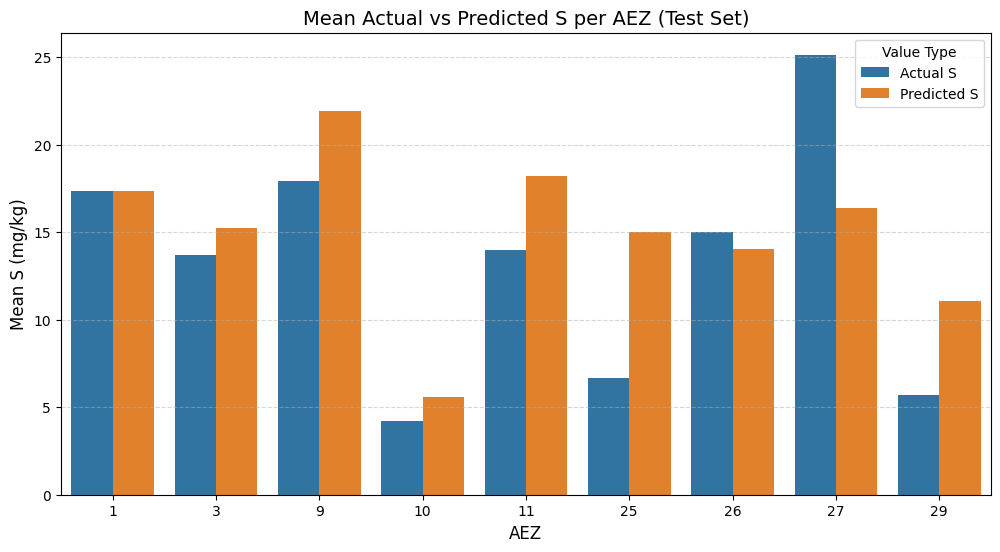

In [1115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Build comparison DataFrame for the test set
# --------------------------------------------------
comparison_df = pd.DataFrame({
    "AEZ": X_test["aez"].values,
    "Actual S": y_test,
    "Predicted S": y_pred.flatten()
})

# --------------------------------------------------
# 2. Compute mean Actual S and Predicted S per AEZ
# --------------------------------------------------
mean_df = comparison_df.groupby("AEZ").agg({
    "Actual S": "mean",
    "Predicted S": "mean"
}).reset_index()

# --------------------------------------------------
# 3. Convert to long format for seaborn grouped bars
# --------------------------------------------------
mean_long = mean_df.melt(
    id_vars="AEZ",
    value_vars=["Actual S", "Predicted S"],
    var_name="Type",
    value_name="Mean S"
)

# --------------------------------------------------
# 4. Plot grouped bar chart
# --------------------------------------------------
plt.figure(figsize=(12,6))

sns.barplot(data=mean_long, x="AEZ", y="Mean S", hue="Type")

plt.title("Mean Actual vs Predicted S per AEZ (Test Set)", fontsize=14)
plt.xlabel("AEZ", fontsize=12)
plt.ylabel("Mean S (mg/kg)", fontsize=12)
plt.legend(title="Value Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [1116]:
import joblib
import os
import json

models_path = "/content/drive/MyDrive/S-prediction/models"
params_path = "/content/drive/MyDrive/S-prediction/params"

model.save(os.path.join(models_path, "s_prediction_model.keras"))

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(os.path.join(models_path,"s_prediction_model.tflite"), 'wb') as f:
    f.write(tflite_model)
tflite_size = os.path.getsize(os.path.join(models_path,"s_prediction_model.tflite")) / 1024  # KB
print(f"TFLite model saved: {tflite_size:.2f} KB")

joblib.dump(scaler_X, os.path.join(params_path, "scaler_X.pkl"))
joblib.dump(encoder_X, os.path.join(params_path, "encoder_X.pkl"))
joblib.dump(scaler_y, os.path.join(params_path, "scaler_y.pkl"))
with open(os.path.join(params_path, "feature_info.json"), "w") as f:
    json.dump({
        "numeric_features": numeric_features,
        "categorical_features": categorical_features
    }, f, indent=4)

Saved artifact at '/tmp/tmpcib7rkfs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13), dtype=tf.float32, name='keras_tensor_127')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139905281543248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139905270238672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139905270240400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139905270235600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139905270239440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139905270239824: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved: 5.74 KB
